# Scores computed on the nino indices over the number of training data

In [1]:
import os, torch, nc_time_axis, yaml
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib as mpl
import matplotlib.pyplot as plt
import cartopy as ctp
from importlib import reload
import hyblim.geoplot as gpl
from hyblim.utils import metric

plt.style.use("../../paper.mplstyle")

def get_model_specs_by_name(experiments, exp_name):
    for exp in experiments:
        if exp['name'] == exp_name:
            return exp 
    return None

def find_files_in_subdir(rootfolder, name='nino_indices.pt'):
    """Find files in subdirectories.

    Args:
        rootfolder (str): Root folder to start search.
        name (str, optional): Name of file to search for. Defaults to 'nino_indices.pt'.
    Returns:
        list: List of files with given name.
    """
    file_list = []
    for dirpath, dirnames, filenames in os.walk(rootfolder):
        for filename in filenames:
            if filename == name:
                file_list.append(os.path.join(dirpath, filename))
    return file_list 

# Load list of experiments
with open("experiments.yaml", "r") as f:
    experiments = yaml.safe_load(f)

## Load nino-indices of experiments and compute score 

In [17]:
load_experiments = ['LIM', 'LSTM', 'LIM+LSTM']
datasplit = 'test'
num_data = [600, 1200, 2400, 3600, 6000, 12000, 18000]


nino_scores, nino_scores_month = {}, {}
for exp_name in load_experiments:
    nino_scores_exp, nino_scores_month_exp, num_traindata = [], [], []
    for n_data in num_data:
        exp = get_model_specs_by_name(experiments, f"{exp_name} (n{n_data})")
        if exp is None:
            print(f"Experiment {exp_name} (n{n_data}) not found")
            continue
        nino_frcst = xr.open_dataset(exp['paths'][0] + '/metrics/nino_frcst_test.nc').transpose('time', 'member', 'lag')
        nino_target = xr.open_dataset(exp['paths'][0] + '/metrics/nino_target_test.nc').transpose('time','lag')

        nino_scores_ndata, nino_scores_month_ndata = metric.time_series_score(nino_frcst, nino_target)
        nino_scores_exp.append(nino_scores_ndata)
        nino_scores_month_exp.append(nino_scores_month_ndata)
        num_traindata.append(n_data)

    # Merge number of data
    nino_scores_exp = metric.listofdicts_to_dictoflists(nino_scores_exp)
    nino_scores_month_exp = metric.listofdicts_to_dictoflists(nino_scores_month_exp)
    nino_scores[exp_name] = {key: xr.concat(values, dim=pd.Index(num_traindata, name='ndata')) for key, values in nino_scores_exp.items()} 
    nino_scores_month[exp_name] = {key: xr.concat(values, dim=pd.Index(num_traindata, name='ndata')) for key, values in nino_scores_month_exp.items()} 


/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/utils/metric.py:208: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_members = frcst.dims['member']
/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/utils/metric.py:208: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  n_members = frcst.dims['member']
/etc/ecmwf/nfs/dh1_home_a/ecm1922/Code/hybridLIM/hyblim/utils/metric.py:208: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names t

## Plot score over number of training data

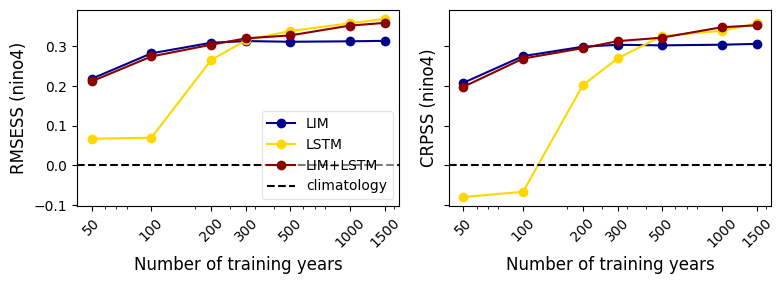

In [33]:
# Line plots 
lag = 9
idx_name = 'nino4'
scores = ['rmsess', 'crpss']
score_label = dict(rmsess=rf'RMSESS ({idx_name})',
                   crpss=rf'CRPSS ({idx_name})',
                   corr=rf'ACC ({idx_name})')
ncols = len(scores)


fig, axs = plt.subplots(1, ncols, figsize=(8, 3),
                        sharex=True, sharey=True)

for i, score_name in enumerate(scores):
    ax = axs[i] if ncols>1 else axs
    for j, (exp_name, exp_scores) in enumerate(nino_scores.items()):
        if score_name not in exp_scores.keys():
            continue
        score = exp_scores[score_name][idx_name].sel(lag=lag)
        exp = get_model_specs_by_name(experiments, exp_name)
        clr = exp['color'] if 'color' in exp else None
        ax.plot(score['ndata'], score.values, color=clr, 
                marker='o', linestyle='-',
                label=exp_name, )
    
    ax.axhline(0, color='k', linestyle='--', label='climatology')    
    if i == 0:
        ax.legend(loc='lower right', fontsize='small')
        
    ax.tick_params(axis='y', labelsize='small')
    ax.set_ylabel(f'{score_label[score_name]}')

    ax.set_xscale('log')
    ax.set_xticks(score['ndata'].values)
    ax.set_xticklabels(score['ndata'].values//12, fontsize='small', rotation=45)
    ax.set_xlabel("Number of training years")

#gpl.enumerate_axes(axs, pos_x=0.02, pos_y=.97, fontsize="medium")

#plt.savefig(f"../../output/paperplots/number_trainingdata.jpg", dpi=1000, bbox_inches="tight")


## Lag time (ACC >0.5) over number of training data 

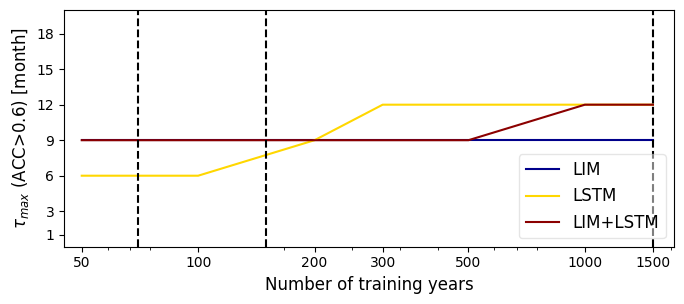

In [34]:
idx_name = 'nino4'
ss_threshold = 0.6
score_name = 'cc'
score_label = dict(rmse_skill=rf'RMSESS',
                   crpss=rf'CRPSS',
                   cc=rf'ACC')

fig, ax = plt.subplots(1, 1, figsize=(7, 3.2))
for i, (exp_name, exp_scores) in enumerate(nino_scores.items()):
    if score_name not in exp_scores.keys():
        continue
    score = exp_scores[score_name][idx_name]

    # Calculate tau_max
    tau_max = np.zeros(len(score['ndata']))
    for n, ndata in enumerate(score['ndata']):
        buff = score.sel(ndata=ndata)
        try:
            tau_max[n] = buff.where(buff>=ss_threshold, drop=True)['lag'].max() 
        except:
            tau_max[n] = np.nan

    tau_max = xr.DataArray(tau_max, coords={'ndata': score['ndata']})

    # Experiment properties
    exp = get_model_specs_by_name(experiments, exp_name)
    clr = exp['color'] if 'color' in exp else None

    ax.plot(tau_max['ndata'], tau_max, label=exp_name, 
            color=clr) 

# Axis
ax.tick_params(axis='y', labelsize='small')
ax.set_ylabel(r"$\tau_{max}$" + f" ({score_label[score_name]}>{ss_threshold}) [month]")
ax.set_yticks(score['lag'])
ax.set_ylim([0, 20])

ax.set_xlim([45*12, 1700*12])
ax.set_xscale('log')
ax.set_xticks(score['ndata'].values)
ax.set_xticklabels(score['ndata'].values//12, fontsize='small')
ax.set_xlabel("Number of training years")

# Legend
ax.legend(fontsize='medium', loc='lower right')

ax.axvline(70*12, color='k', linestyle='--')
ax.axvline(150*12, color='k', linestyle='--')
ax.axvline(1500*12, color='k', linestyle='--')

#gpl.enumerate_axes(axs, pos_x=0.02, pos_y=.97, fontsize="medium")

